Estimated Gaussian noise standard deviation = 0.14788329855515528


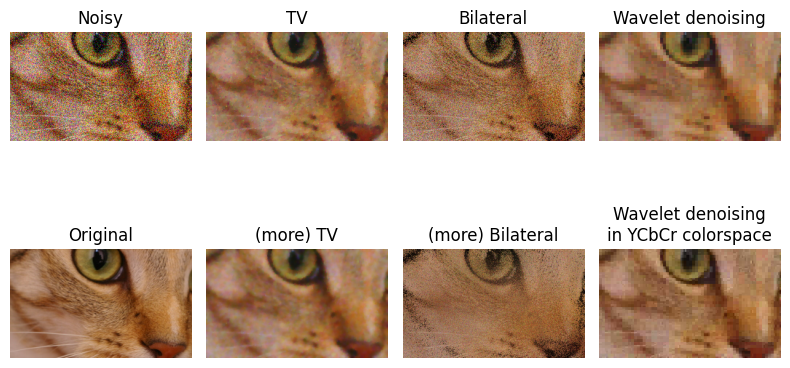

In [24]:
import matplotlib.pyplot as plt

from skimage.restoration import (
    denoise_tv_chambolle,
    denoise_bilateral,
    denoise_wavelet,
    estimate_sigma,
)
from skimage import data, img_as_float
from skimage.util import random_noise


original = img_as_float(data.chelsea()[100:250, 50:300])

sigma = 0.155
noisy = random_noise(original, var=sigma**2)

fig, ax = plt.subplots(nrows=2, ncols=4, figsize=(8, 5), sharex=True, sharey=True)

plt.gray()

# Estimate the average noise standard deviation across color channels.
sigma_est = estimate_sigma(noisy, channel_axis=-1, average_sigmas=True)
# Due to clipping in random_noise, the estimate will be a bit smaller than the
# specified sigma.
print(f'Estimated Gaussian noise standard deviation = {sigma_est}')

ax[0, 0].imshow(noisy)
ax[0, 0].axis('off')
ax[0, 0].set_title('Noisy')
ax[0, 1].imshow(denoise_tv_chambolle(noisy, weight=0.1, channel_axis=-1))
ax[0, 1].axis('off')
ax[0, 1].set_title('TV')
ax[0, 2].imshow(
    denoise_bilateral(noisy, sigma_color=0.05, sigma_spatial=15, channel_axis=-1)
)
ax[0, 2].axis('off')
ax[0, 2].set_title('Bilateral')
ax[0, 3].imshow(denoise_wavelet(noisy, channel_axis=-1, rescale_sigma=True))
ax[0, 3].axis('off')
ax[0, 3].set_title('Wavelet denoising')

ax[1, 1].imshow(denoise_tv_chambolle(noisy, weight=0.2, channel_axis=-1))
ax[1, 1].axis('off')
ax[1, 1].set_title('(more) TV')
ax[1, 2].imshow(
    denoise_bilateral(noisy, sigma_color=0.1, sigma_spatial=15, channel_axis=-1)
)
ax[1, 2].axis('off')
ax[1, 2].set_title('(more) Bilateral')
ax[1, 3].imshow(
    denoise_wavelet(noisy, channel_axis=-1, convert2ycbcr=True, rescale_sigma=True)
)
ax[1, 3].axis('off')
ax[1, 3].set_title('Wavelet denoising\nin YCbCr colorspace')
ax[1, 0].imshow(original)
ax[1, 0].axis('off')
ax[1, 0].set_title('Original')

fig.tight_layout()

plt.show()

In [1]:
import cv2
import os

# Path to the video file
video_path = '/content/vid.mp4'  # replace with your video file name
output_folder = 'extracted_frames'

# Create output directory if it doesn't exist
if not os.path.exists(output_folder):
    os.makedirs(output_folder)

# Load the video
cap = cv2.VideoCapture(video_path)

# Check if video opened successfully
if not cap.isOpened():
    print("Error: Could not open video.")
    exit()

frame_count = 0

while True:
    ret, frame = cap.read()  # Read one frame
    if not ret:
        break  # Break when no more frames

    # Construct filename and save frame
    frame_filename = os.path.join(output_folder, f"frame_{frame_count:04d}.jpg")
    cv2.imwrite(frame_filename, frame)

    frame_count += 1

print(f"✅ Done! {frame_count} frames extracted to '{output_folder}'.")

# Release the video capture object
cap.release()


✅ Done! 236 frames extracted to 'extracted_frames'.


✅ Videos saved in 'processed_videos'.
✅ Collage saved as 'collage.jpg'.


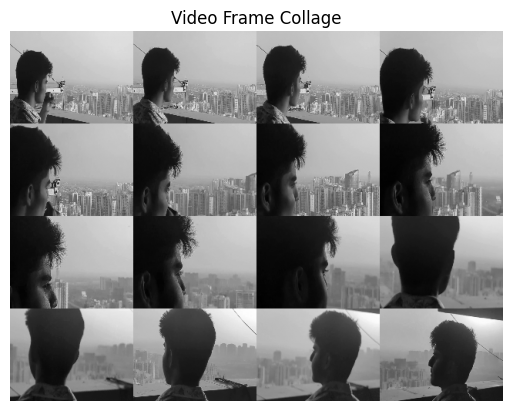

In [3]:
import cv2
import os
import numpy as np
import matplotlib.pyplot as plt

video_path = '/content/vid.mp4'
output_dir = 'processed_videos'
collage_output = 'collage.jpg'
os.makedirs(output_dir, exist_ok=True)

# Open video
cap = cv2.VideoCapture(video_path)
if not cap.isOpened():
    print("❌ Could not open video.")
    exit()

# Get video properties
fps = int(cap.get(cv2.CAP_PROP_FPS))
frame_width = int(cap.get(3))
frame_height = int(cap.get(4))
size = (frame_width, frame_height)
fourcc = cv2.VideoWriter_fourcc(*'mp4v')

# Setup output video writers
out_thresh = cv2.VideoWriter(os.path.join(output_dir, 'adaptive_thresh.mp4'), fourcc, fps, size, isColor=False)
out_blur = cv2.VideoWriter(os.path.join(output_dir, 'gaussian_blur.mp4'), fourcc, fps, size, isColor=False)
out_canny = cv2.VideoWriter(os.path.join(output_dir, 'canny_edge.mp4'), fourcc, fps, size, isColor=False)
out_bitwise = cv2.VideoWriter(os.path.join(output_dir, 'bitwise_not.mp4'), fourcc, fps, size, isColor=False)

collage_frames = []

frame_index = 0
while True:
    ret, frame = cap.read()
    if not ret:
        break

    gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)

    # 1. Adaptive Thresholding
    thresh = cv2.adaptiveThreshold(gray, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C,
                                   cv2.THRESH_BINARY, 11, 2)

    # 2. Gaussian Smoothing
    blur = cv2.GaussianBlur(gray, (5, 5), 0)

    # 3. Canny Edge Detection
    canny = cv2.Canny(gray, 100, 200)

    # 4. Bitwise NOT
    bitwise = cv2.bitwise_not(gray)

    # Write frames to respective video outputs
    out_thresh.write(thresh)
    out_blur.write(blur)
    out_canny.write(canny)
    out_bitwise.write(bitwise)

    # Collect a few frames for collage
    if frame_index % 10 == 0 and len(collage_frames) < 16:
        collage_frames.append(cv2.resize(gray, (160, 120)))

    frame_index += 1

cap.release()
out_thresh.release()
out_blur.release()
out_canny.release()
out_bitwise.release()

print(f"✅ Videos saved in '{output_dir}'.")

# Create collage
if collage_frames:
    rows = 4
    cols = 4
    collage_image = np.zeros((rows * 120, cols * 160), dtype=np.uint8)

    for idx, img in enumerate(collage_frames):
        r = idx // cols
        c = idx % cols
        collage_image[r*120:(r+1)*120, c*160:(c+1)*160] = img

    cv2.imwrite(collage_output, collage_image)
    print(f"✅ Collage saved as '{collage_output}'.")

    # Optional display
    plt.imshow(collage_image, cmap='gray')
    plt.title('Video Frame Collage')
    plt.axis('off')
    plt.show()
else:
    print("⚠️ Not enough frames for collage.")


In [9]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("pevogam/ucf101")

print("Path to dataset files:", path)

100%|██████████| 6.49G/6.49G [01:03<00:00, 109MB/s] 

Extracting files...


Path to dataset files: /root/.cache/kagglehub/datasets/pevogam/ucf101/versions/1


In [14]:
import os
import cv2
import numpy as np
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import TimeDistributed, LSTM, Dense, GlobalAveragePooling2D
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical

# Parameters
NUM_FRAMES = 16
IMG_SIZE = 128
DATA_PATH = '/root/.cache/kagglehub/datasets/pevogam/ucf101/versions/1/UCF101/UCF-101'
CLASSES = ['BenchPress', 'ApplyLipstick', 'Billiards', 'BlowDryHair', 'JumpRope']  # Your selected classes
NUM_CLASSES = len(CLASSES)

# --- Load and preprocess videos ---
def load_video(path, max_frames=NUM_FRAMES):
    cap = cv2.VideoCapture(path)
    frames = []
    while len(frames) < max_frames:
        ret, frame = cap.read()
        if not ret:
            break
        frame = cv2.resize(frame, (IMG_SIZE, IMG_SIZE))
        frames.append(frame)
    cap.release()
    # Pad if not enough frames
    while len(frames) < max_frames:
        frames.append(frames[-1])
    return np.array(frames[:max_frames])

X, y = [], []

for label, action in enumerate(CLASSES):
    folder = os.path.join(DATA_PATH, action)
    for file in os.listdir(folder)[:10]:
        if file.endswith('.avi'):
            path = os.path.join(folder, file)
            video = load_video(path)
            X.append(video)
            y.append(label)

X = np.array(X)
y = np.array(y)
y_cat = to_categorical(y, NUM_CLASSES)

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y_cat, test_size=0.2, random_state=42)


In [15]:
# --- Build CNN + LSTM Model ---
cnn = MobileNetV2(weights='imagenet', include_top=False, input_shape=(IMG_SIZE, IMG_SIZE, 3))

model = Sequential([
    TimeDistributed(cnn, input_shape=(NUM_FRAMES, IMG_SIZE, IMG_SIZE, 3)),
    TimeDistributed(GlobalAveragePooling2D()),
    LSTM(64),
    Dense(64, activation='relu'),
    Dense(NUM_CLASSES, activation='softmax')
])

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()

# Train the model
history = model.fit(X_train, y_train, epochs=10, batch_size=2, validation_data=(X_test, y_test))


9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/wrapper.py:27: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ time_distributed                │ (None, 16, 4, 4, 1280) │     2,257,984 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_1              │ (None, 16, 1280)       │             0 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm (LSTM)                     │ (None, 64)             │       344,320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 64)             │         4,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 5)              │           325 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,606,789 (9.94 MB)

 Trainable params: 2,572,677 (9.81 MB)

 Non-trainable params: 34,112 (133.25 KB)

Epoch 1/10
20/20 ━━━━━━━━━━━━━━━━━━━━ 223s 2s/step - accuracy: 0.4100 - loss: 1.4719 - val_accuracy: 0.3000 - val_loss: 1.2211
Epoch 2/10
20/20 ━━━━━━━━━━━━━━━━━━━━ 13s 361ms/step - accuracy: 0.4651 - loss: 1.4674 - val_accuracy: 0.2000 - val_loss: 1.3696
Epoch 3/10
20/20 ━━━━━━━━━━━━━━━━━━━━ 10s 346ms/step - accuracy: 0.3151 - loss: 1.5009 - val_accuracy: 0.4000 - val_loss: 1.4877
Epoch 4/10
20/20 ━━━━━━━━━━━━━━━━━━━━ 11s 383ms/step - accuracy: 0.5150 - loss: 1.3146 - val_accuracy: 0.5000 - val_loss: 1.2625
Epoch 5/10
20/20 ━━━━━━━━━━━━━━━━━━━━ 10s 400ms/step - accuracy: 0.3904 - loss: 1.3437 - val_accuracy: 0.5000 - val_loss: 1.3897
Epoch 6/10
20/20 ━━━━━━━━━━━━━━━━━━━━ 10s 396ms/step - accuracy: 0.4303 - loss: 1.6319 - val_accuracy: 0.5000 - val_loss: 1.3427
Epoch 7/10
20/20 ━━━━━━━━━━━━━━━━━━━━ 10s 374ms/step - accuracy: 0.5048 - loss: 1.2700 - val_accuracy: 0.5000 - val_loss: 1.3071
Epoch 8/10
20/20 ━━━━━━━━━━━━━━━━━━━━ 10s 347ms/step - accuracy: 0.3446 - loss: 1.3025 - val_accura

In [25]:
# --- Evaluation ---
y_pred = model.predict(X_test)
y_pred_labels = np.argmax(y_pred, axis=1)
y_true = np.argmax(y_test, axis=1)

print("Confusion Matrix:")
print(confusion_matrix(y_true, y_pred_labels))

print("\nClassification Report:")
print(classification_report(y_true, y_pred_labels, target_names=CLASSES))


1/1 ━━━━━━━━━━━━━━━━━━━━ 23s 23s/step
Confusion Matrix:
[[0 0 0 0 0]
 [1 0 0 2 0]
 [0 0 2 0 0]
 [0 0 0 3 0]
 [0 0 0 2 0]]

Classification Report:
               precision    recall  f1-score   support

   BenchPress       0.00      0.00      0.00         0
ApplyLipstick       0.00      0.00      0.00         3
    Billiards       1.00      1.00      1.00         2
  BlowDryHair       0.43      1.00      0.60         3
     JumpRope       0.00      0.00      0.00         2

     accuracy                           0.50        10
    macro avg       0.29      0.40      0.32        10
 weighted avg       0.33      0.50      0.38        10



/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_

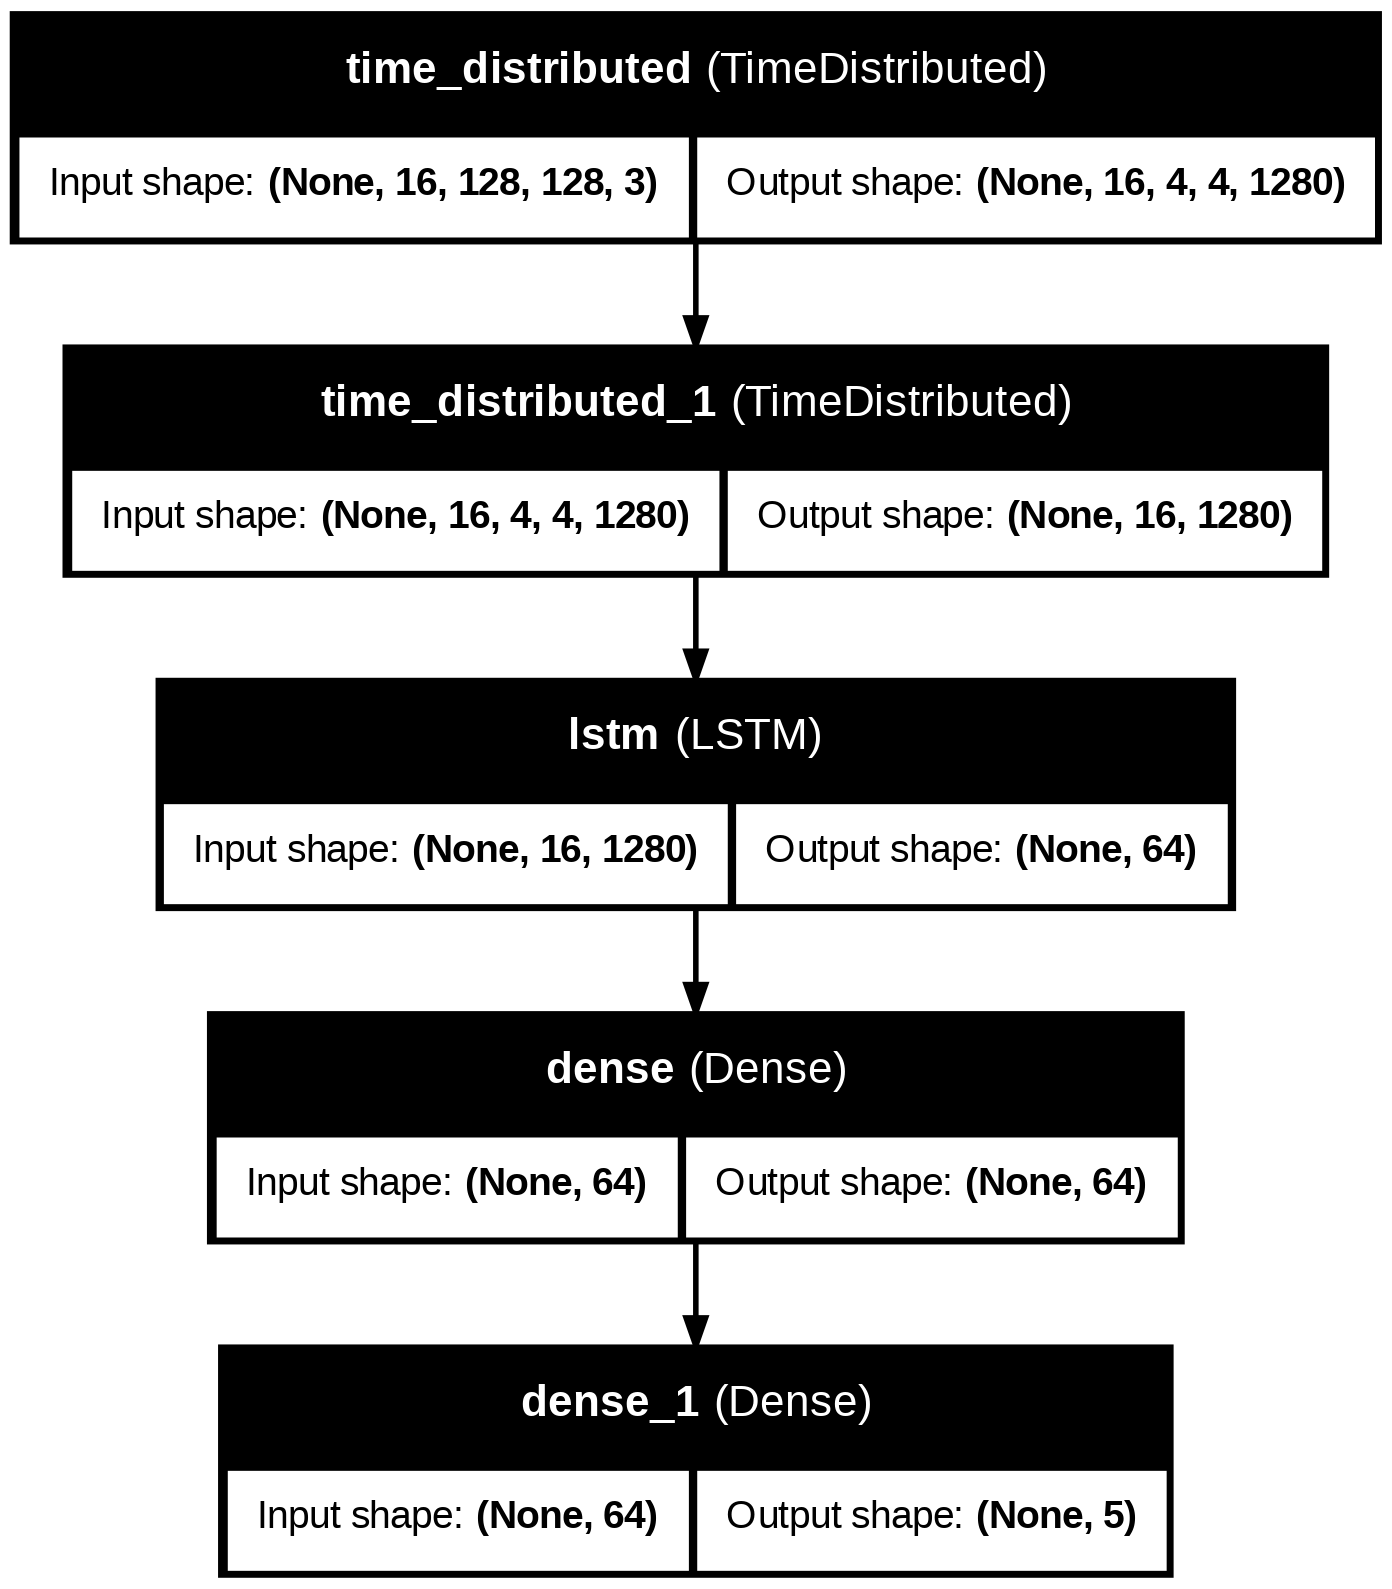

In [27]:
from tensorflow.keras.utils import plot_model
plot_model(model,to_file='model_view.png',show_shapes=True,show_layer_names=True)

In [35]:
def create_dataset():
  features = []
  labels = []
  video_path = []
  for index, name in enumerate(target_class):
    print(f'Extracting data of class: {name}')
    file_list = os.listdir(os.path.join(dataset_dir, name))

    # Initialize a counter for each class
    class_counter = 0

    for file_name in file_list:
      if class_counter >= 25:  # Break if we have 10 videos for this class
        break

      path = os.path.join(dataset_dir, name, file_name)
      frames = frame_extraction(path)
      if len(frames) == seq_len:
        features.append(frames)
        labels.append(index)
        video_path.append(path)
        class_counter += 1  # Increment the counter for this class

  features = np.asarray(features)
  labels = np.array(labels)
  return features, labels, video_path

In [37]:
import time
start_time=time.time()
hist=model.fit(x=X_train,y=y_train,epochs=25,batch_size=8,shuffle=True,validation_split=0.2)
end_time=time.time()
print(f'Training time is {end_time-start_time} seconds')

Epoch 1/25
4/4 ━━━━━━━━━━━━━━━━━━━━ 228s 9s/step - accuracy: 0.6417 - loss: 0.9745 - val_accuracy: 0.1250 - val_loss: 1.9051
Epoch 2/25
4/4 ━━━━━━━━━━━━━━━━━━━━ 2s 529ms/step - accuracy: 0.6042 - loss: 1.2948 - val_accuracy: 0.3750 - val_loss: 1.4560
Epoch 3/25
4/4 ━━━━━━━━━━━━━━━━━━━━ 2s 525ms/step - accuracy: 0.6125 - loss: 0.9963 - val_accuracy: 0.5000 - val_loss: 1.0968
Epoch 4/25
4/4 ━━━━━━━━━━━━━━━━━━━━ 2s 529ms/step - accuracy: 0.8917 - loss: 0.6010 - val_accuracy: 0.3750 - val_loss: 1.1594
Epoch 5/25
4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 533ms/step - accuracy: 0.8417 - loss: 0.6749 - val_accuracy: 0.5000 - val_loss: 1.1947
Epoch 6/25
4/4 ━━━━━━━━━━━━━━━━━━━━ 2s 579ms/step - accuracy: 0.8875 - loss: 0.4438 - val_accuracy: 0.5000 - val_loss: 1.0965
Epoch 7/25
4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 563ms/step - accuracy: 0.8500 - loss: 0.4317 - val_accuracy: 0.6250 - val_loss: 1.2248
Epoch 8/25
4/4 ━━━━━━━━━━━━━━━━━━━━ 2s 531ms/step - accuracy: 0.8958 - loss: 0.4300 - val_accuracy: 0.8750 - val_loss: 

In [39]:
eval_hist=model.evaluate(X_train,y_train)


2/2 ━━━━━━━━━━━━━━━━━━━━ 26s 139ms/step - accuracy: 0.9729 - loss: 0.1210


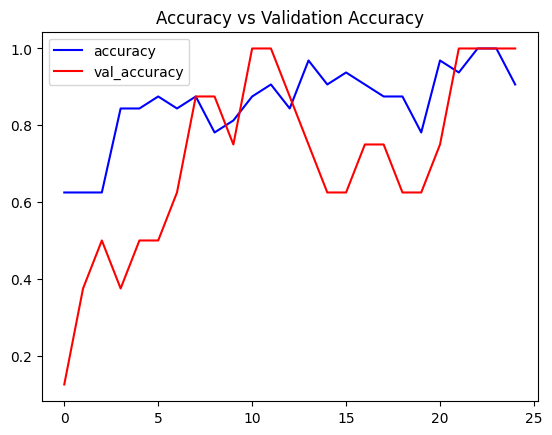

In [40]:
#ACCURACY
x=hist.history['accuracy']
epochs=range(len(x))
plt.plot(epochs,x,'blue',label='accuracy')
plt.plot(epochs,hist.history['val_accuracy'],'red',label='val_accuracy')
plt.title('Accuracy vs Validation Accuracy')
plt.legend()

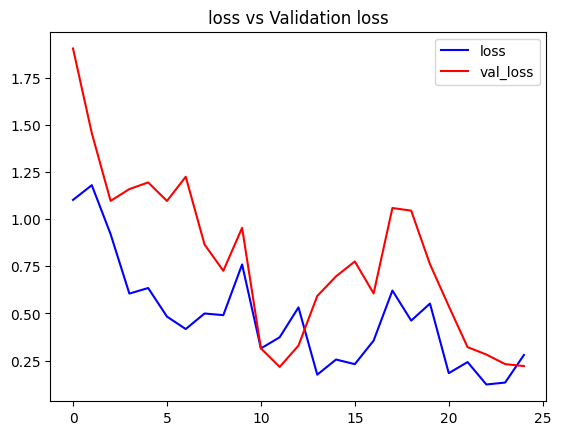

In [41]:
#LOSS
x=hist.history['loss']
epochs=range(len(x))
plt.plot(epochs,x,'blue',label='loss')
plt.plot(epochs,hist.history['val_loss'],'red',label='val_loss')
plt.title('loss vs Validation loss')
plt.legend()